Basemap: https://basemaptutorial.readthedocs.io/en/latest/basemap.html
https://matplotlib.org/basemap/users/graticule.html

wrf python example: https://wrf-python.readthedocs.io/en/latest/plot.html
matplotlib coloar map: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html  
draw lat long lines: https://matplotlib.org/basemap/users/graticule.html
skew-T: https://unidata.github.io/MetPy/latest/installguide.html
https://wxster.com/blog/2015/12/plotting-skew-t-diagrams-in-python#wrf

In [67]:
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from mpl_toolkits.basemap import Basemap
from wrf import to_np, getvar, smooth2d, get_basemap, latlon_coords
import numpy as np
#import Ngl,Nio
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import wrf


#import metpy
#from metpy.cbook import get_test_data
#from metpy.interpolate import log_interpolate_1d
#from metpy.plots import add_metpy_logo, add_timestamp
#from metpy.units import units


In [2]:
ncfile = Dataset(r'G:\toronto-research\python\wrfout_d01_2010-08-22_12_00_00')


# Draw background map

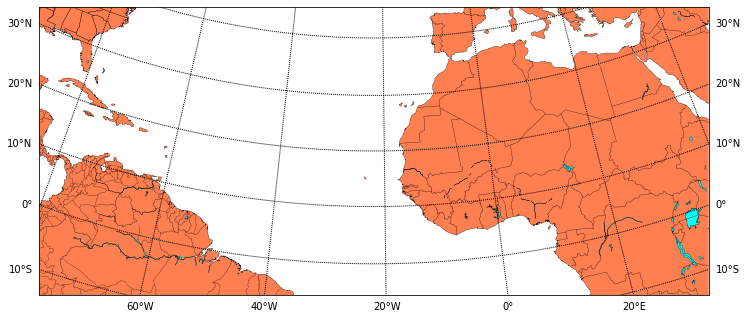

In [54]:

# Extract the pressure, geopotential height, and wind variables
p = wrf.getvar(ncfile, "pressure")


    # Get the lat/lon coordinates
lats, lons = wrf.latlon_coords(p)

# (2) create base figure

    # Create the figure
fig = plt.figure(figsize=(12,9))
ax = plt.axes()

    # Get the basemap object
bm = wrf.get_basemap(p,  projection='lcc')


# (6) lat lon label
parallels = np.arange(-90.0, 90.0, 10.)
bm.drawparallels(parallels,labels=[True,True,False,False])
meridians = np.arange(-180,180,20.)
bm.drawmeridians(meridians,labels=[False,False,False,True])


# (7) Add the geographic boundaries
bm.drawcoastlines(linewidth=0.3)
bm.drawstates(linewidth=0.25)
bm.drawcountries(linewidth=0.3)
bm.fillcontinents(color='coral',lake_color='aqua')


plt.show()

# Plotting a Two-Dimensional Field


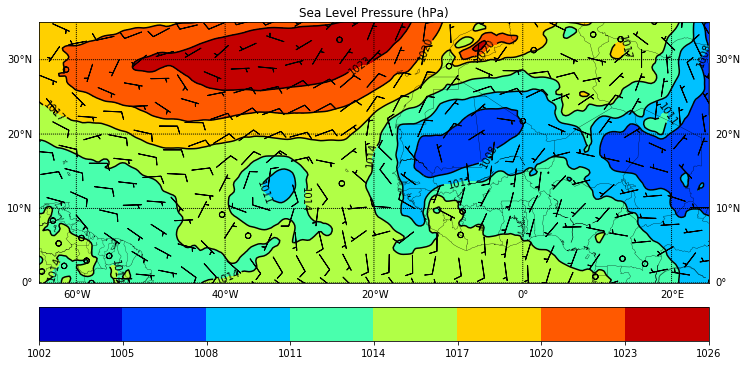

In [47]:
# (1) Process the data

slp = wrf.getvar(ncfile, "slp", units='hPa')
# Smooth the sea level pressure since it tends to be noisy near the
# mountains
slp = wrf.smooth2d(slp, 3, cenweight=4)
u10 = wrf.getvar(ncfile, "U10")
v10 = wrf.getvar(ncfile, "V10")


    # Get the lat/lon coordinates
lats, lons = wrf.latlon_coords(slp)

# (2) create base figure

    # Create the figure
fig = plt.figure(figsize=(12,9))
ax = plt.axes()

    # Get the basemap object
bm = wrf.get_basemap(slp,  projection='cyl', llcrnrlon=-65, llcrnrlat=0, urcrnrlon=25, urcrnrlat=35)

    # Convert the lat/lon coordinates to x/y coordinates in the projection space
x, y = bm(wrf.to_np(lons), wrf.to_np(lats) )

# (3)  contour

contours = bm.contour(x, y, wrf.to_np(slp), colors="black") # Make a contour plot over the map
plt.clabel(contours, inline=True, fontsize=10, fmt="%i") # Label contour

# (4)  filled contour

wspd_contours = bm.contourf(x, y, wrf.to_np(slp),  cmap=get_cmap("jet")) 
plt.colorbar(wspd_contours, ax=ax, orientation="horizontal", pad=0.05) # pad is margin
    
# (5)  vector

density = 10
bm.barbs(x[::density,::density], y[::density,::density], to_np(u10[::density, ::density]), 
         to_np(v10[::density, ::density]), length=6, color='black') 


# (6) lat lon
parallels = np.arange(-50.0, 90.0, 10.)
bm.drawparallels(parallels,labels=[True,True,False,False])
meridians = np.arange(-180,180,20.)
bm.drawmeridians(meridians,labels=[False,False,False,True])

# (7) Add the geographic boundaries
bm.drawcoastlines(linewidth=0.3)
bm.drawstates(linewidth=0.25)
bm.drawcountries(linewidth=0.3)


# (8) add title and other info
plt.title("Sea Level Pressure (hPa)")
#plt.colorbar(shrink=.62)
plt.show()
#plt.savefig('test.pdf')

# Horizontal Interpolation to a Pressure Level


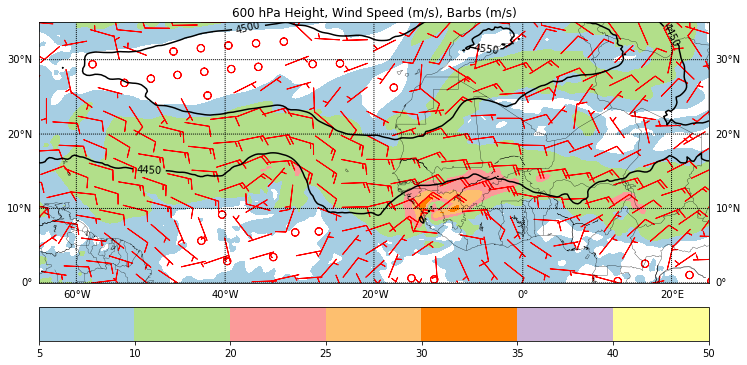

In [41]:
# (1) Process the data

    # Extract the pressure, geopotential height, and wind variables
p = wrf.getvar(ncfile, "pressure")
z = wrf.getvar(ncfile, "z", units="m")
ua = wrf.getvar(ncfile, "ua", units="m/s")
va = wrf.getvar(ncfile, "va", units="m/s")
wspd = wrf.getvar(ncfile, "wspd_wdir", units="m/s")[0,:]

pressure_levels = 600    #?

    # Interpolate geopotential height, u, and v winds to 600 hPa
ht_p = wrf.interplevel(z, p, pressure_levels)
u_p = wrf.interplevel(ua, p, pressure_levels)
v_p = wrf.interplevel(va, p, pressure_levels)
wspd_p = wrf.interplevel(wspd, p, pressure_levels)

    # Get the lat/lon coordinates
lats, lons = wrf.latlon_coords(ht_p)

# (2) create base figure

    # Create the figure
fig = plt.figure(figsize=(12,9))
ax = plt.axes()

    # Get the basemap object
bm = wrf.get_basemap(ht_p,  projection='cyl', llcrnrlon=-65, llcrnrlat=0, urcrnrlon=25, urcrnrlat=35)


    # Convert the lat/lon coordinates to x/y coordinates in the projection space
x, y = bm(wrf.to_np(lons), wrf.to_np(lats) )

# (3)  contour

    # Add the 600 hPa geopotential height contours
cn_levels = np.arange(4000., 5500., 50.) # contour intervals #?
contours = bm.contour(x, y, wrf.to_np(ht_p), levels=cn_levels, colors="black") # Make a contour plot over the map
plt.clabel(contours, inline=True, fontsize=10, fmt="%i") # Label contour

# (4)  filled contour

    # Add the wind speed filled contours
cn_levels = [5, 10, 20, 25, 30, 35, 40, 50]
wspd_contours = bm.contourf(x, y, wrf.to_np(wspd_p), levels=cn_levels, cmap=get_cmap("Paired")) 
plt.colorbar(wspd_contours, ax=ax, orientation="horizontal", pad=0.05) # pad is margin
    
# (5)  vector

    # Add the 600 hPa wind barbs, only plotting every 10th data point.
density = 10
bm.barbs(x[::density,::density], y[::density,::density], to_np(u_p[::density, ::density]), 
         to_np(v_p[::density, ::density]), length=7, color='red') 
                            # 25 is for density, length is size

# () streamline
# wind_stream = bm.streamplot(x, y, wrf.to_np(u_600), wrf.to_np(v_600), color='blue') 

# (6) lat lon label
parallels = np.arange(-50.0, 90.0, 10.)
bm.drawparallels(parallels,labels=[True,True,False,False])
meridians = np.arange(-180,180,20.)
bm.drawmeridians(meridians,labels=[False,False,False,True])

# (7) Add the geographic boundaries
bm.drawcoastlines(linewidth=0.3)
bm.drawstates(linewidth=0.25)
bm.drawcountries(linewidth=0.3)


# (8) add title and other info
plt.title("600 hPa Height, Wind Speed (m/s), Barbs (m/s)")
plt.show()

# Vertical Cross Section


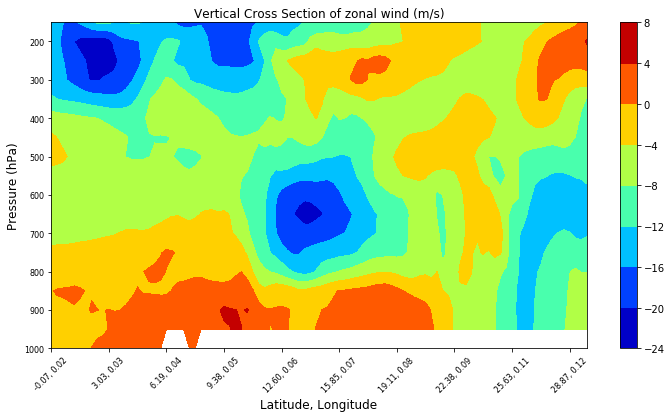

In [37]:
#########
# setting
#########

# (1) along the line, 
start_point = wrf.CoordPair(lat=0, lon=0)    
end_point = wrf.CoordPair(lat=30, lon=0)
interval_x = 10    # intervals for the ticks

# (2) vertical 

vertical_type=2    # 1 is the height coordinate, 2 is pressure coordinate
dd = {1: range(0, 10000, 500), 2: range(1000, 100, -50) }
levels = dd[vertical_type] 

interval_z = 2      

##########


#############################
# Extract the model variables
############################

z = wrf.getvar(ncfile, "z", units='m')   # model height
p = wrf.getvar(ncfile, 'pressure')   # model pressure
wspd = wrf.getvar(ncfile, "ua", units='m/s')

    # Compute the vertical cross-section interpolation.  Also, include the
    # lat/lon points along the cross-section.  wspd_cross.shape = (100, 94)

if vertical_type == 1:   
    wspd_cross = wrf.vertcross(wspd, z, wrfin=ncfile, levels=levels, start_point=start_point, end_point=end_point, latlon=True, meta=True)
else:
    wspd_cross = wrf.vertcross(wspd, p, wrfin=ncfile, levels=levels, start_point=start_point, end_point=end_point, latlon=True, meta=True)


##############
# plot
#################

    # Create the figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()

    # Make the contour plot
wspd_contours = ax.contourf(wrf.to_np(wspd_cross), cmap=get_cmap("jet"))

    # Add the color bar
plt.colorbar(wspd_contours, ax=ax)

######################
# set ticks and labels
#####################
    
    # (1) Set the x-ticks to use latitude and longitude labels.
coord_pairs = wrf.to_np(wspd_cross.coords["xy_loc"])

"""
array([CoordPair(x=259.0, y=22.0, lat=-0.06695556640625, lon=0.017822265625),
   CoordPair(x=258.8709677419355, y=23.0, lat=0.24075071513652802, lon=0.018775202333927155),
   CoordPair(x=258.741935483871, y=24.0, lat=0.5490284562110901, lon=0.019716324284672737),
"""
    
x_ticks = np.arange(coord_pairs.shape[0]) 
"""
array([ 0,  1,  2, ....93])
"""
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in wrf.to_np(coord_pairs)]

"""
['-0.07, 0.02',
 '0.24, 0.02',
 '0.55, 0.02',
"""

ax.set_xticks(x_ticks[::interval_x])
ax.set_xticklabels(x_labels[::interval_x], rotation=45, fontsize=8)


    # (2) set z ticks and labels
    
vert_vals = levels
v_ticks = range(len(levels))

ax.set_yticks(v_ticks[::interval_z])
ax.set_yticklabels(vert_vals[::interval_z], fontsize=8)

# Set the x-axis and  y-axis labels

ax.set_xlabel("Latitude, Longitude", fontsize=12)

if vertical_type == 1:
    ax.set_ylabel("Height (m)", fontsize=12)
else:
    ax.set_ylabel("Pressure (hPa)", fontsize=12)


plt.title("Vertical Cross Section of zonal wind (m/s)")

plt.show()
# plt.savefig('test.pdf',bbox_inches='tight')

<Figure size 432x288 with 0 Axes>